# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
3. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [1]:
# подготовка данных
import psycopg2
import pandas as pd
import sqlite3

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)

cursor = conn.cursor()

# получаем имена таблиц из базы
sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"
cursor.execute(sql_str)
tables_data = [a for a in cursor.fetchall()]
conn.commit()

print("Какие таблицы содержатся в Postgres: %s" % tables_data)

Какие таблицы содержатся в Postgres: [('hr_dataset',), ('production_staff',), ('male',), ('female',), ('recruiting_costs',), ('salary_grid',), ('show_functions',), ('share_employee_source',)]


In [9]:
# посмотрим зависит ли национальность на оценку производительности
sql_nac_ps = """SELECT
                    "Race Desc",
                    "Performance Score",
                    SUM(1) AS sum
                FROM production_staff
                GROUP BY "Race Desc","Performance Score"
                ORDER BY sum DESC
            """

In [10]:
df_nac_ps = pd.read_sql_query(sql_nac_ps, conn)
df_nac_ps

,Race Desc,Performance Score,sum
0,White,Fully Meets,80
1,None,None,47
2,Black or African American,Fully Meets,20
3,White,N/A- too early to review,19
4,White,Exceeds,15
5,White,90-day meets,14
6,Asian,Fully Meets,14
7,Two or more races,Fully Meets,5
8,White,Needs Improvement,5
9,Black or African American,Needs Improvement,5


**Из таблицы видно что лучшие показатели у White и Black or African American**

In [12]:
# Давайте посмотрим есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

df = pd.read_sql_query("""SELECT
                            hr_dataset.age AS age,
                            AVG(hr_dataset."Days Employed") AS mean_days,
                            MIN(hr_dataset."Days Employed") AS min_days,
                            MAX(hr_dataset."Days Employed") AS max_days
                        FROM hr_dataset
                        GROUP BY age
                        ORDER BY mean_days DESC LIMIT 5
                        
                        """, conn)
df

,age,mean_days,min_days,max_days
0,50,2055.666667,510,4339
1,49,1995.000000,972,2766
2,25,1843.500000,1476,2211
3,40,1709.125000,194,3244
4,58,1635.000000,1635,1635


**как видно в топ 5 вошел возраст порядка 50 лет**

In [3]:
# посмотрим какая раса дольше работает 
df = pd.read_sql_query("""SELECT
                            production_staff."Race Desc" AS race,
                            AVG(hr_dataset."Days Employed") AS mean_days,
                            MIN(hr_dataset."Days Employed") AS min_days,
                            MAX(hr_dataset."Days Employed") AS max_days
                            
                        FROM production_staff
                        JOIN hr_dataset ON hr_dataset."Employee Name" = production_staff."Employee Name"
                        GROUP BY race
                        ORDER BY mean_days DESC
                        
                        """, conn)
df

,race,mean_days,min_days,max_days
0,American Indian or Alaska Native,2061.333333,1518,2336
1,Two or more races,1602.300000,45,3065
2,Black or African American,1466.064516,98,3674
3,Hispanic,1359.333333,2,2148
4,Asian,1282.863636,19,2583
5,White,1229.661871,2,3611


In [4]:
import matplotlib.pyplot as plt

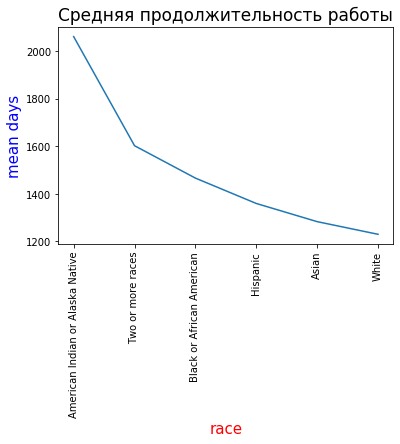

In [9]:
df_graf = df.copy()
df_graf.index = df_graf.race
plt.plot(df_graf.race.values, df_graf.mean_days.values)
plt.xlabel('race', fontsize=15, color='red')
plt.ylabel('mean days', fontsize=15, color='blue')
plt.title('Средняя продолжительность работы', fontsize=17)
plt.xticks(df.race.values, rotation='vertical', labels=df.race.values)
plt.show()

**Интресные данные, но все же мы видим что Black or African American остаются в приоритете, самых рассматриваемых к найму сотрудников, так как по ним лучшая производительность и они дольше не меняют места работы**

In [7]:
# Есть зависимость между perfomance score и тем, под чьим руководством работает сотрудник. Как правило у какого руководителя
# большее количество показателей, не важно плохих или положительных то это и считается показателем зависимости
sql_str1 = """SELECT 
                "Manager Name" ,
                "Performance Score", 
                SUM(1) AS sum,
                row_number() OVER (ORDER BY SUM(1) DESC)  AS rating
            FROM hr_dataset
            GROUP BY "Manager Name" ,"Performance Score"
            ORDER BY sum DESC, "Manager Name" ASC"""

In [8]:
df_ps = pd.read_sql(sql_str1, conn)
df_ps

,Manager Name,Performance Score,sum,rating
0,David Stanley,Fully Meets,15,1
1,Kelley Spirea,Fully Meets,15,2
2,Ketsia Liebig,Fully Meets,14,4
3,Kissy Sullivan,Fully Meets,14,3
4,Elijiah Gray,Fully Meets,13,5
5,Janet King,Fully Meets,13,6
6,Amy Dunn,Fully Meets,11,9
7,John Smith,Fully Meets,11,7
8,Webster Butler,Fully Meets,11,8
9,Michael Albert,Fully Meets,9,10


**Если считать Performance Score - "Fully Meets" как признак который полностью удовлетворяет сотрудников под чьим началом они работают, то здраво сделать предположение что новых сотрудников и возможно сотрудников с проблемной оценкой лучше включать  состав команд топовых руководителей которых мы видим в таблице**

In [10]:
# Есть зависимость зарплат сотрудников между perfomance score и тем, под чьим руководством работает сотрудник и в каком отделе.
sql_hr = """SELECT 
                AVG("Pay Rate") AS pay, 
                "Manager Name",
                "Performance Score", 
                department
            FROM hr_dataset 
            GROUP BY "Manager Name","Performance Score", department
            ORDER BY pay DESC"""

In [11]:
df_hr = pd.read_sql(sql_hr, conn)
df_hr

,pay,Manager Name,Performance Score,department
0,80.000000,Board of Directors,Fully Meets,Executive Office
1,65.000000,Jennifer Zamora,Exceptional,IT/IS
2,65.000000,Janet King,Exceptional,IT/IS
3,64.000000,Jennifer Zamora,Exceeds,IT/IS
4,63.000000,Jennifer Zamora,Needs Improvement,IT/IS
5,60.000000,Janet King,Fully Meets,Sales
6,57.125000,Debra Houlihan,Fully Meets,Sales
7,56.666667,Janet King,Exceeds,Production
8,56.559999,Alex Sweetwater,90-day meets,Software Engineering
9,56.000000,Lynn Daneault,PIP,Sales


**мы видим зависимость по зарплате от того кто руководит, в качестве образца можно взять руководителей "Janet King" или "Jennifer Zamora", под их руководством самые высокие средние зарплаты. И новых сотрудников так же лучше включать в команду к этим руководителям для денежной стимуляции.**

**Заключение:** Как видно из полученных данных, а именно что:
&nbsp;&nbsp;&nbsp;&nbsp; - лучшие оценки производительности у White и Black or African American <br>
&nbsp;&nbsp;&nbsp;&nbsp; - большая продолжительность работы у сотрудников в возрасте 50 лет <br>
&nbsp;&nbsp;&nbsp;&nbsp; - так же дольше продолжительность больше у рас American Indian or Alaska Native, Two or more races и Black or African American <br>
&nbsp;&nbsp;&nbsp;&nbsp; - новых и проблемных сотрудников желательно включать в команду под руководством топ 10 руководителей показаных в таблицах (см. выше) <br>
И нарисовывается картина, что в приоритете на прием нового сотрудника это "Black or African American", в возрасте близком к 50, а в качестве работы с уже имеющимися сотрудниками выходят по расе "White" так как по ним высокие оценки, но низкая продолжительность работы на одном месте ( капризные , зазнайки какие то, либо же просто белые знают себе цену )

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

In [0]:
### YOUR CODE HERE ###


